Building a classification model that classify bank transactions into accounting categories by using the
transaction descriptions. 

In [1]:
import pandas as pd 

data_feat = pd.read_csv("bank_transaction_features.csv") 
data_label = pd.read_csv("bank_transaction_labels.csv") 

data_combined = pd.merge(data_label, data_feat)

In [2]:
labels = data_combined.bank_transaction_type.map(dict(MPO=0, DEB=1, CSH = 2, CHG = 3, DD = 4, FPO = 5)).tolist()

In [3]:
data_combined.head()

,bank_transaction_id,bank_transaction_category,bank_transaction_dataset,bank_transaction_description,bank_transaction_amount,bank_transaction_type
0,21786195,TRAVEL,TRAIN,citylink,-13.80,MPO
1,21786196,TRAVEL,TRAIN,citylink,-13.14,DEB
2,21786197,TRAVEL,TRAIN,1Jul19 OYSTER,-36.98,DEB
3,21786198,TRAVEL,TRAIN,travelodge,-75.73,MPO
4,21786199,TRAVEL,TRAIN,6Jul19 RINGGO,-37.86,CSH


In [51]:
from io import StringIO

#creating useful dictionaries for later
col = ['bank_transaction_category', 'bank_transaction_description', 'bank_transaction_dataset']
data_combined = data_combined[col]
data_combined = data_combined[pd.notnull(data_combined['bank_transaction_description'])] #remove null values
data_combined.columns = ['bank_transaction_category', 'bank_transaction_description', 'bank_transaction_dataset']
data_combined['category_id'] = data_combined['bank_transaction_category'].factorize()[0] #creating category id to classify labels
category_id_df = data_combined[['bank_transaction_category', 'category_id']].drop_duplicates().sort_values('category_id') #dataframe for category labels and category
category_to_id = dict(category_id_df.values) #creating dictionary from category to id
id_to_category = dict(category_id_df[['category_id', 'bank_transaction_category']].values) #reverse dict.

category_id_df.head(5)

,bank_transaction_category,category_id
0,TRAVEL,0
2510,MOTOR_EXPENSES,1
3660,ACCOMMODATION_AND_MEALS,2
6830,BANK_OR_FINANCE_CHARGES,3
9080,INSURANCE,4


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Using and calculating a measure called Term Frequency, Inverse Document Frequency. Create a vector for each description:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(data_combined['bank_transaction_description'].values.astype('U'))
labels = data_combined.category_id
features.shape

(12369, 1230)

In [6]:
from sklearn.feature_selection import chi2
import numpy as np

#Find most correlated terms using sklearn.feature_selection.chi2
N = 2
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

data_combined.loc[data_combined["bank_transaction_dataset"] == 'TRAIN']

#Load in training and test sets
X_train = data_combined.loc[data_combined["bank_transaction_dataset"] == 'TRAIN', 'bank_transaction_description']
X_test = data_combined.loc[data_combined["bank_transaction_dataset"] == 'VAL', 'bank_transaction_description']
y_train = data_combined.loc[data_combined["bank_transaction_dataset"] == 'TRAIN', 'category_id']
y_test = data_combined.loc[data_combined["bank_transaction_dataset"] == 'VAL', 'category_id']

#Train the model using a multinomial variant of Naive Bayes Classifier
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train) #trained model

Let us test this model quickly on one of our descriptions in the dataset to see if it works:

In [8]:
text ='1Jul19 OYSTER' #predictive text

In [9]:
print(clf.predict(count_vect.transform([text])))

[0]


In [14]:
data_combined[data_combined['bank_transaction_description'] == text]

,bank_transaction_category,bank_transaction_description,bank_transaction_dataset,category_id
2,TRAVEL,1Jul19 OYSTER,TRAIN,0


We can see that it predicts the category correctly!

Now let us use our trained model onto our test/validation dataset to see how it fares in accuracy.

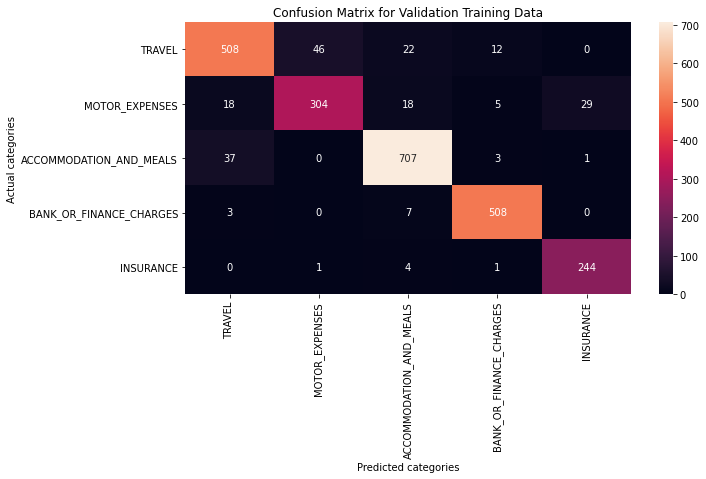

In [35]:
#Running on our validation dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#using model on our test dataset to get our predictions
prediction = clf.predict(count_vect.transform(X_test))

#plotting a confusion matrix/heatmap of our predictions on our test dataset
matrix = confusion_matrix(y_test, prediction) #comparing actual labels with
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(matrix, annot = True, fmt = 'd', xticklabels = category_id_df.bank_transaction_category.values, yticklabels = category_id_df.bank_transaction_category.values)
plt.ylabel('Actual categories')
plt.xlabel('Predicted categories')
plt.title('Confusion Matrix for Validation Training Data')
plt.show()

We can see that most of the terms lie on our diagonal, which means our model has accurately predicted the category. Areas in which there seems to be most error are:
1. Predicted Motor, but actually travel
2. Predicted Travel, but actually Accomodation/Meals
3. Predicted Insurance, but actually motor expenses

In [45]:
from IPython.display import display

#getting indexes of our validation test set
index = data_combined.index
condition = data_combined["bank_transaction_dataset"] == "VAL"
val_indices = index[condition]

#looking into the misclassifications
for pred in category_id_df.category_id: #iterating over our possible category indexes
    for actual in category_id_df.category_id:
        if pred != actual and matrix[actual, pred] >= 25: #for our off-diagonals, where confusion matrix has value more than 25
            print(f'Category {id_to_category[actual]} mispredicted as {id_to_category[pred]}: {matrix[actual, pred]} examples.')
            display(data_combined.loc[val_indices[(y_test == actual) & (prediction == pred)]][['bank_transaction_category', 'bank_transaction_description']])
            print(' ')

Category ACCOMMODATION_AND_MEALS mispredicted as TRAVEL: 37 examples.


,bank_transaction_category,bank_transaction_description
10957,ACCOMMODATION_AND_MEALS,premier inn
11005,ACCOMMODATION_AND_MEALS,ON 9 Aug premier inn
11015,ACCOMMODATION_AND_MEALS,ON 2019-8-6 premier inn
11098,ACCOMMODATION_AND_MEALS,premier inn CONTACTLESS
11122,ACCOMMODATION_AND_MEALS,PREMIER INN 31Aug19
11133,ACCOMMODATION_AND_MEALS,best western
11140,ACCOMMODATION_AND_MEALS,CARD PAYMENT PREMIER INN ON 5 Aug
11156,ACCOMMODATION_AND_MEALS,ON 7 Aug CONTACTLESS premier inn
11166,ACCOMMODATION_AND_MEALS,ON 2019-7-2 TRAVELODGE
11194,ACCOMMODATION_AND_MEALS,premier inn



Category TRAVEL mispredicted as MOTOR_EXPENSES: 46 examples.


,bank_transaction_category,bank_transaction_description
10013,TRAVEL,VIA MOBILE ONLINE ringgo mobile parking
10016,TRAVEL,fuel service station ON 7 Aug
10026,TRAVEL,TESCO GARAGE PETROL 12Jul19
10039,TRAVEL,SUNDRY DEBIT smart parking chelsea london
10048,TRAVEL,Fin: tesco garage petrol
10059,TRAVEL,SMART PARKING CHELSEA LONDON
10072,TRAVEL,23Aug19 ENTERPRISE RENT A
10075,TRAVEL,SUNDRY DEBIT camden parking ON 2019-8-16
10082,TRAVEL,Sundry debit: ON 2019-7-19 CONTACTLESS fuel se...
10095,TRAVEL,fuel service station ON 9 Jul



Category MOTOR_EXPENSES mispredicted as INSURANCE: 29 examples.


,bank_transaction_category,bank_transaction_description
10580,MOTOR_EXPENSES,Fin: ADMIRAL INSURANCE
10608,MOTOR_EXPENSES,ADMIRAL INSURANCE
10648,MOTOR_EXPENSES,Direct Debit halfords
10670,MOTOR_EXPENSES,axa insurance
10687,MOTOR_EXPENSES,INSURANCE
10693,MOTOR_EXPENSES,axa insurance ON 2019-8-25
10719,MOTOR_EXPENSES,ON 2019-8-8 DIRECTLINE INS
10723,MOTOR_EXPENSES,directline ins
10724,MOTOR_EXPENSES,DIRECTLINE INS
10746,MOTOR_EXPENSES,VIA MOBILE ONLINE axa insurance ON 2019-8-14


We can use the above to help deduce why the error occurs for our three points above:

1. Predicted Motor, but actually travel
Alot of these examples involve some form of the word 'parking', 'motor', and 'fuel', of which all are likely to be words indicative of motor expenses as well. 

2. Predicted Travel, but actually Accomodation/Meals
We can see that in most of these descriptions, it includes the word 'travel' in the description, which would then make sense as to why our model predicts 'travel' instead of accommodation/meals. 

3. Predicted Insurance, but actually motor expenses
We can also see here that most of these examples have the word 'insurance' under their description, which is also heavily suggestive it could be in the 'insurance' category instead, and thus probably caused our model to mispredict.

To improve performance, we would probably have to put more emphasis on the correct separation of the categories above, or splitting it up into further categories, as we can see that some of them overlap quite a bit, e.g. insurance that also counts as motor expenses.

Our final classification report is given below:

In [48]:
from sklearn import metrics

print(metrics.classification_report(y_test, prediction, target_names = data_combined['bank_transaction_category'].unique()))

                         precision    recall  f1-score   support

                 TRAVEL       0.90      0.86      0.88       588
         MOTOR_EXPENSES       0.87      0.81      0.84       374
ACCOMMODATION_AND_MEALS       0.93      0.95      0.94       748
BANK_OR_FINANCE_CHARGES       0.96      0.98      0.97       518
              INSURANCE       0.89      0.98      0.93       250

               accuracy                           0.92      2478
              macro avg       0.91      0.92      0.91      2478
           weighted avg       0.92      0.92      0.92      2478



We can overall see that the average prediction accuracy is at 92%, which is very good.